<a href="https://github.com/97jake/WildfireSegmentation/blob/main/PerimeterDetectionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip3 install torch
# !pip3 install torchvision
# !pip3 install tqdm
#!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
from google.colab import drive
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [ ]:
#Adjust according to your system
#Path should be where images and labels are stored
path = '/content/gdrive/MyDrive'
image_filename = 'final_augmented_image.npy'
label_filename = 'final_augmented_labels.npy'

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, images, labels):

      self.images = images
      self.labels = labels

  def __getitem__(self,index):
    img = self.images[index]
    label = self.labels[index]
    return img,label
  
  def __len__(self):
    return self.images.shape[0]

In [ ]:
#Network follows a UNet architecture.
#For more info, see https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

class BurnDetection(nn.Module):
  def __init__(self): # BurnDetection constructor
    super(BurnDetection, self).__init__()

    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3,padding=1,stride=2)
    
    self.conv1 = nn.Conv2d(3,64,kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 1)

    self.conv5 = nn.Conv2d(64,128, kernel_size=3,stride = 1,padding=1)
    self.conv7 = nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)

    self.conv9 = nn.Conv2d(128,256, kernel_size=3,stride = 1,padding=1)
    self.conv11 = nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)

    self.conv13 = nn.Conv2d(256,512, kernel_size=3,stride = 1,padding=1)
    self.conv15 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.conv17 = nn.Conv2d(512,1024, kernel_size=3,stride = 1,padding=1)
    self.conv19 = nn.Conv2d(1024,1024,kernel_size=3,stride=1,padding=1)

    self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)

    self.conv21 = nn.Conv2d(1024,512, kernel_size=3,stride = 1,padding=1)
    self.conv23 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)

    self.conv25 = nn.Conv2d(512,256, kernel_size=3,stride = 1,padding=1)
    self.conv27 = nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)

    self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)

    self.conv29 = nn.Conv2d(256,128, kernel_size=3,stride = 1,padding=1)
    self.conv31 = nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)

    self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)

    self.conv33 = nn.Conv2d(128,64, kernel_size=3,stride = 1,padding=1)
    self.conv35 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)

    self.finalconv = nn.Conv2d(64,2,kernel_size=3,stride=1, padding=1)

 
  def forward(self, input): # nn.Module sets up a hook that calls forward when you "call" the module object: net(x) calls net.forward(x)
    conv1_out = self.conv1(input)
    relu2_out = self.relu(conv1_out)
    conv3_out = self.conv3(relu2_out)
    relu4_out = self.relu(conv3_out) 
    down1 = self.maxpool(relu4_out)

    conv5_out = self.conv5(down1)
    relu6_out = self.relu(conv5_out)
    conv7_out = self.conv7(relu6_out)
    relu8_out = self.relu(conv7_out)
    down2 = self.maxpool(relu8_out)

    conv9_out = self.conv9(down2)
    relu10_out = self.relu(conv9_out)
    conv11_out = self.conv11(relu10_out)
    relu12_out = self.relu(conv11_out)
    down3 = self.maxpool(relu12_out)

    conv13_out = self.conv13(down3)
    relu14_out = self.relu(conv13_out)
    conv15_out = self.conv15(relu14_out)
    relu16_out = self.relu(conv15_out)
    down4 = self.maxpool(relu16_out)
    
    conv17_out = self.conv17(down4)
    relu18_out = self.relu(conv17_out)
    conv19_out = self.conv19(relu18_out)
    relu20_out = self.relu(conv19_out)
    up1 = self.up1(relu20_out)

    conc1 = torch.cat((relu16_out,up1), dim=1)

    conv21_out = self.conv21(conc1)
    relu22_out = self.relu(conv21_out)
    conv23_out = self.conv23(relu22_out)
    relu24_out = self.relu(conv23_out)
    up2 = self.up2(relu24_out)

    conc2 = torch.cat((relu12_out,up2), dim=1)
    conv25_out = self.conv25(conc2)
    relu26_out = self.relu(conv25_out)
    conv27_out = self.conv27(relu26_out)
    relu28_out = self.relu(conv27_out)
    up3 = self.up3(relu28_out)
    conc3 = torch.cat((relu8_out,up3), dim=1)

    conv29_out = self.conv29(conc3)
    relu30_out = self.relu(conv29_out)
    conv31_out = self.conv31(relu30_out)
    relu32_out = self.relu(conv31_out)
    up4 = self.up4(relu32_out)
    conc4 = torch.cat((relu4_out,up4), dim=1)

    conv33_out = self.conv33(conc4)
    relu34_out = self.relu(conv33_out)
    conv35_out = self.conv35(relu34_out)
    relu36_out = self.relu(conv35_out)

    final = self.finalconv(relu36_out)

    return final.squeeze(2).squeeze(2)


In [ ]:
#This function implements union/intersection accuracy, a good metric for accuracy of image segmentation problems
def union_intersection_accuracy(y_hat,y_truth):
  y_hat = y_hat.cpu().detach().numpy()
  y_truth = y_truth.cpu().detach().numpy()
  union = np.argmax(y_hat, axis=1) * y_truth
  intersection = np.argmax(y_hat, axis=1) + y_truth > 0

  return np.mean(np.sum(union,axis=(1,2)) / np.sum(intersection,axis=(1,2)))

In [ ]:
def scope(num_epochs = 50, loading = False):

  print("Loading data...")
  images = torch.Tensor(np.load(os.path.join(root, image_filename))).permute(0,3,1,2)
  labels = torch.Tensor(np.load(os.path.join(root, label_filename))) / 255.

  #Split data into training and validation sets
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1) 
  training = ImageDataset(X_train, y_train)
  validation = ImageDataset(X_test, y_test)

  #Grab first image from training set to keep track of model performance along the way
  img = training[0][0]

  #Batch number, adjust if memory errors occur
  batch_num = 5
  current_epoch = 0

  train_loader = DataLoader(training,
                            batch_size=batch_num,
                            pin_memory=True,
                            shuffle=True,
                            num_workers=2)
  val_loader = DataLoader(validation,
                          batch_size=batch_num,
                          pin_memory=True,
                          shuffle=True,
                          num_workers=2)
  
  print("Loaded train_loader")
  
  model = BurnDetection()
  model.cuda()
  print("Loaded model")

  # Initialize Objective and Optimizer and other parameters
  objective = nn.CrossEntropyLoss()

  optimizer = optim.Adam(model.parameters(),lr=1e-4)


  #This code loads saved models if loading is set to true
  #Adjust path and filename if necessary
  if loading:
    checkpoint = torch.load(os.path.join(path, 'model_in_training.tar'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    current_epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    model.train()


  # Run your training and validation loop and collect stats
  losses = []
  val_loss = []
  val_accuracy = []
  accuracies = []
  prediction_images = [img]



  #This should help some with memory issues
  gc.collect()
  torch.cuda.empty_cache()
  
  #For epoch in number of epochs
  for epoch in range(current_epoch, num_epochs):

    loop = tqdm(total=len(train_loader), position=0, leave=False)

    for batch, (x, y_truth) in enumerate(train_loader):
      x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)
      optimizer.zero_grad()
      
      #Predict
      y_hat = model(x)
      
      #Calculate loss
      loss = objective(y_hat, y_truth.long())
      loss.backward()
      losses.append(loss.item())
      
      #Get accuracy every 50 batches
      if batch % 50 == 0:
        accuracy = (y_hat.argmax(1) == y_truth).float().mean()
        accuracies.append(accuracy)

      loop.set_description('epoch{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch,loss,accuracy))
      loop.update(1)
      
      optimizer.step()

      #Calculate validation set score every so often
      if batch % batch_num == 0:
        val = np.mean([objective(model(x.cuda()), y.cuda().long()).item() for x,y in val_loader])
        val_loss.append((len(losses), val))

        val_a = torch.Tensor([(model(x.cuda()).argmax(1) == y.cuda()).float().mean() for x,y in val_loader]).mean().item()
        val_accuracy.append((len(losses), val_a))

    #Save model after every epoch
    #This allows runtime to shutdown or for you to quit training and pick up where you left off
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, os.path.join('/content/gdrive/MyDrive', 'model_in_training.tar'))
    
    #Predict label of starter image to track model performance
    prediction_images.append(model(img.unsqueeze(0).cuda()).argmax(1).cpu()[0])
      
    loop.close()

  
  return model, losses, val_loss, accuracies, val_accuracy, prediction_images



In [ ]:
#Number of epochs to train model for
num_epochs = 12

#Change this if you want to load in a pre-existing model.
#Usually done when training was interrupted and you want to pick up where you left off
#Important note - If you are going to load a model, you have to run all the cells above this first
loading = False

model, losses, val_loss, accuracies, val_accuracy, prediction_images = scope(num_epochs, loading=loading)

Loading data...
Loaded train_loader


Loaded model


1.396926464


epoch2, loss:0.5506, accuracy:0.818:  57%|█████▋    | 126/221 [11:07<04:35,  2.90s/it]

# How'd We Do?

The following code is plotting things to measure model performance and see how the model did!

In [ ]:
#Change this value if you want to save the following plots of model performance to the specified folder.
save_images = False
folder = 'ModelPerformance'

In [ ]:
if save_images:

  if not os.path.exists(os.path.join(path, folder)):
      os.makedirs(os.path.join(path, folder))
      print("Created folder '{}' for performance images!".format(folder))
  perf_path = os.path.join(path, folder)
  
  os.chdir(perf_path)

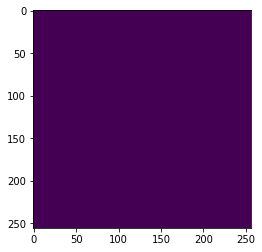

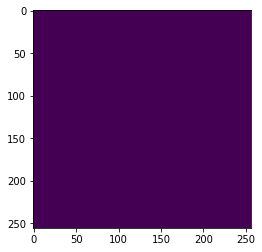

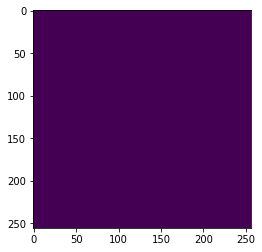

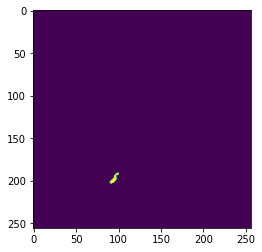

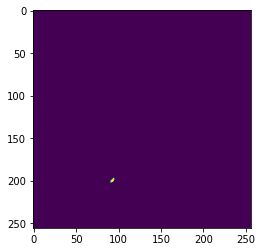

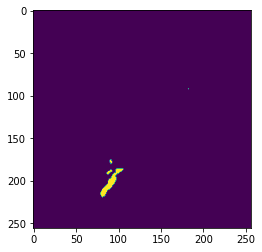

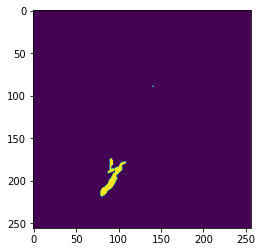

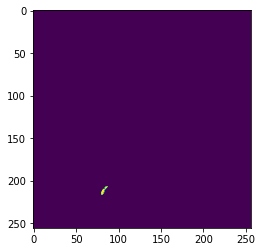

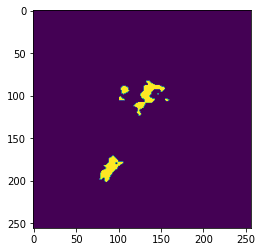

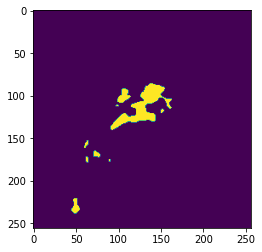

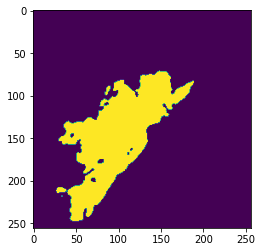

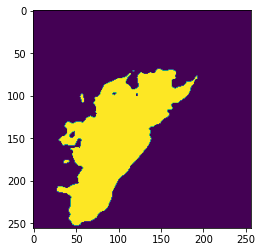

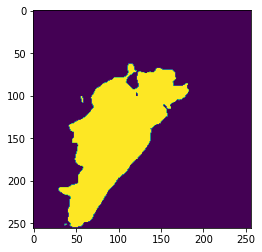

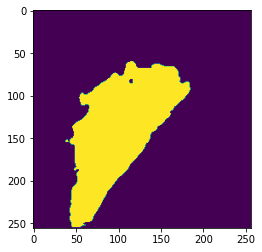

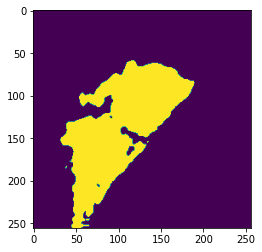

In [ ]:
for i,im in enumerate(prediction_images):

  plt.imshow(im)
  
  if save_images:
    plt.savefig('performance_image{}.jpg'.format(i))
    
  plt.show()

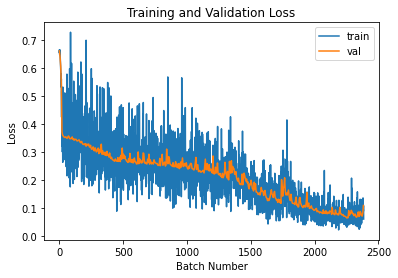

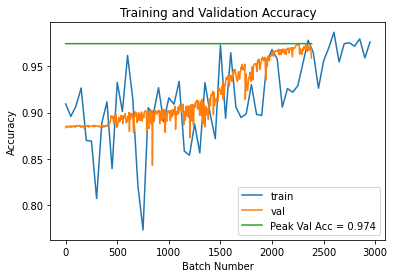

In [ ]:
# Plotting training/validation loss and accuracy
a,b = zip(*val_loss)

plt.plot(losses,label='train')
plt.plot(a,b, label='val')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
if save_images: 
  plt.savefig('train_val_loss.jpg')
plt.show()

a,b = zip(*val_accuracy)

plt.plot([i*50 for i in range(len(accuracies))],accuracies,label='train')
plt.plot(a,b, label='val')
plt.plot([max(b)]*len(losses), label = "Peak Val Acc = {:.3f}".format(max(b)))
plt.title("Training and Validation Accuracy")
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.legend()
if save_images:
  plt.savefig('train_val_acc.jpg')
plt.show()

# Test Data Performance

At this point, if you kept some data aside as a test set, the following code will see how well your model did on the novel data.

In [ ]:
#Load in latest model version (should be model at time of last epoch)
model = torch.load(os.path.join(path, 'trained_model.pt'))
model.eval()

BurnDetection(
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv17): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv19): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
  (conv21): Conv2

In [ ]:
#Load in test data and labels
#Adjust path and filenames accordingly
test_data = torch.Tensor(np.load(os.path.join(path, 'test_data.npy'))).permute(0,3,1,2)
test_labels = torch.Tensor(np.load(os.path.join(path, 'test_labels.npy'))) / 255.

In [ ]:
#Predict on each test image
preds = torch.zeros_like(test_labels)

for i, img in enumerate(test_data):
  preds[i] = model(img.unsqueeze(0).cuda()).argmax(1).cpu()[0]

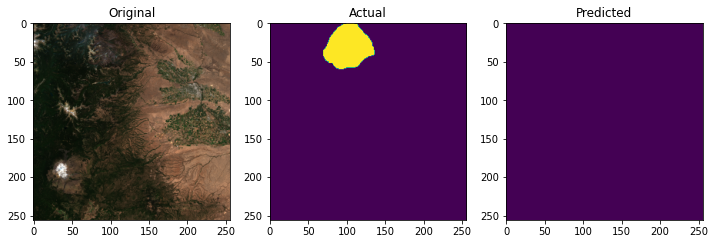

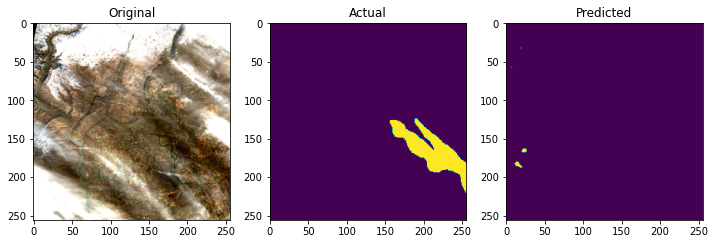

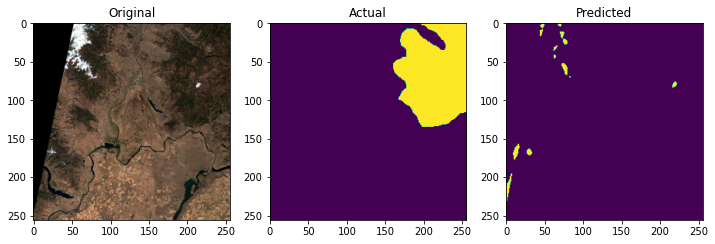

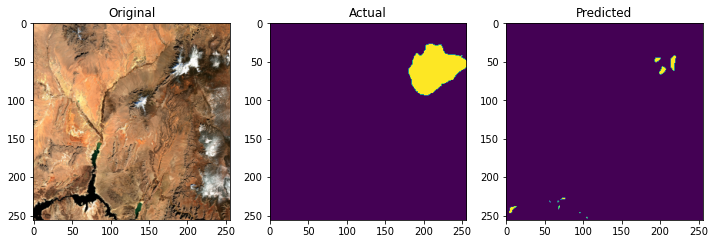

In [ ]:
#Plot
for i, im in enumerate(test_data):
  fig,ax = plt.subplots(1,3,figsize=(12,12))
  ax[0].imshow(im.permute(1,2,0).type(torch.int))
  ax[0].set_title("Original")
  ax[1].imshow(test_labels[i])
  ax[1].set_title("Actual")
  ax[2].imshow(preds[i])
  ax[2].set_title("Predicted")
  if save_images:
    plt.savefig('test_performance{}.jpg'.format(i))
  plt.show()